## Global update with `Dask`

`Dask` is a framework that allows to add parallelization to code in Python. To install the extra dependencies (not added in `pyproject.toml` yet):

In [1]:
%%bash
python -m pip install dask distributed --upgrade

Couldn't find program: 'bash'


`graphviz` (or `cytoscape`) is also needed to visualize the task graph.

In [1]:
from dask.distributed import Client, LocalCluster

# client = Client()
client = Client(n_workers=12)
client # Displays the information of the local client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 12,Total memory: 15.77 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61943,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.77 GiB
Comm: tcp://127.0.0.1:62041,Total threads: 1
Dashboard: http://127.0.0.1:62042/status,Memory: 1.31 GiB
Nanny: tcp://127.0.0.1:61956,


This creates automatically a Dask 'Client' given by our system specificaition. One can then go to the link in the previous block to see `Dask dashboard`, which enables us to see the task stream and other useful information live during the computation.

`procedures.py` functions adapted to Dask framework:

In [2]:
import itertools
import functools
import numpy as np
import tnad.FeatureMap as fm
from tnad.losses import loss_miss, loss_reg
from tnad.gradients import gradient_miss, gradient_reg
import math
import quimb.tensor as qtn
import quimb as qu

from tqdm import tqdm
import dask 


def get_sample_grad(sample, embed_func, P, P_rem, tensor):
    # create MPS for input sample
    phi, _ = fm.embed(sample.flatten(), embed_func)

    #calculate gradient
    grad_miss = gradient_miss(phi, P, P_rem, [tensor])
    return grad_miss

def get_sample_loss(sample, embed_func, P):
    # create MPS for input sample
    phi, _ = fm.embed(sample.flatten(), embed_func)

    #calculate loss
    loss_miss_batch = loss_miss(phi, P)
    return loss_miss_batch

def get_total_grad(P, tensor, data, embed_func, batch_size, alpha):
    P_rem = P.copy(deep=True)
    
    site_tag = P_rem.site_tag(tensor)
    # remove site tag of poped sites
    P_rem.delete(site_tag, which="any")

    # parallelize
    grad_miss = []
    for i, sample in enumerate(data):
        output_per_sample = dask.delayed(get_sample_grad)(sample, embed_func, P, P_rem, tensor)
        grad_miss.append(output_per_sample)
    
    # gradient of loss miss
    grad_miss = dask.delayed(sum)(grad_miss)
    grad_miss.drop_tags()
    grad_miss.add_tag(site_tag)
    # gradient of loss reg
    grad_regular = gradient_reg(P, P_rem, alpha, [tensor])
    if grad_regular != 0:
        grad_regular.drop_tags()
        grad_regular.add_tag(site_tag)
    # total gradient
    total_grad = (1/batch_size)*(grad_miss) + grad_regular
    return total_grad

def global_update_costfuncnorm(P, n_epochs, n_iters, data, batch_size, alpha, lamda_init, bond_dim, decay_rate=None, expdecay_tol=None):
    loss_array = []
    n_tensors = P.nsites
    
    for epoch in range(n_epochs):
        for it in (pbar := tqdm(range(n_iters))):        
            pbar.set_description("Epoch #"+str(epoch)+", sample in batch:")
            # parallelize
            grad_per_tensor=[]
            for tensor in range(n_tensors):
                embed_func = fm.trigonometric
                output_per_tensor = dask.delayed(get_total_grad)(P, tensor, data[it], embed_func, batch_size, alpha) # get grad per tensor
                grad_per_tensor.append(output_per_tensor)
            
            # get loss per sample
            loss_miss = 0
            for i, sample in enumerate(data[it]):
                embed_func = fm.trigonometric
                output_per_sample = dask.delayed(get_sample_loss)(sample, embed_func, P)
                loss_miss += output_per_sample
            # get total loss
            total_loss = (1/batch_size)*(loss_miss) + loss_reg(P, alpha)
            loss_array.append(total_loss)

            # update P
            # no need to parallelize
            for tensor in range(n_tensors):
                site_tag = P.site_tag(tensor)
                tensor_orig = P.select_tensors(site_tag, which="any")
                
                if epoch > expdecay_tol:
                    if decay_rate != None:
                        # exp. decay of lamda
                        lamda = lamda_init*math.pow((1 - decay_rate/100),epoch)
                        tensor_orig = tensor_orig - lamda*grad_per_tensor[tensor]
                else:
                    tensor_orig = tensor_orig - lamda_init*grad_per_tensor[tensor]
                
    return P, loss_array

Arguments for the optimization process:

In [5]:
# args
train_size = 1024
batch_size = 32
strides = (2,2)
pool_size = (2,2)
padding = 'same'
reduced_shape = (14,14)
opt_procedure = 'automatic_differentiation' # 'global_update_costfuncnorm' # 
spacing = 8
n_epochs = 2
alpha = 0.4
lamda_init = 2e-3
lamda_init_2 = 2e-3
decay_rate = 0.01
expdecay_tol = 10
bond_dim = 5
init_func = 'normal'
scale_init_p = 0.5

In [4]:
%%time

from tnad.optimization import train_SMPO, load_mnist_train_data, data_preprocessing
import tnad.procedures as p

train_data = load_mnist_train_data(train_size=train_size, seed=123456)
data = data_preprocessing(train_data, strides=strides, pool_size=pool_size, padding=padding, reduced_shape=reduced_shape)

if opt_procedure == 'local_update_sweep_dyncanonization_renorm':
    opt_procedure = p.local_update_sweep_dyncanonization_renorm
elif opt_procedure == 'global_update_costfuncnorm':
    opt_procedure = p.global_update_costfuncnorm
elif opt_procedure == 'automatic_differentiation':
    opt_procedure = functools.partial(p.automatic_differentiation, alg_depth=2, jit_fn=False, par_client=client) # this now also works with dask!

P, loss_array = train_SMPO(data, spacing, n_epochs, alpha, opt_procedure, lamda_init, lamda_init_2, decay_rate, expdecay_tol, bond_dim, init_func, scale_init_p, batch_size, seed=123456,)
loss_array

Epoch #0, sample in batch::   3%|▎         | 1/32 [00:20<10:29, 20.30s/it]


 loss 959.8132934570312


Epoch #0, sample in batch::   6%|▋         | 2/32 [00:23<05:11, 10.39s/it]


 loss 2248.327880859375


Epoch #0, sample in batch::   9%|▉         | 3/32 [00:26<03:18,  6.85s/it]


 loss 714.2861938476562


Epoch #0, sample in batch::  12%|█▎        | 4/32 [00:29<02:34,  5.52s/it]


 loss 245.49444580078125


Epoch #0, sample in batch::  16%|█▌        | 5/32 [00:33<02:08,  4.77s/it]


 loss 94.51713562011719


Epoch #0, sample in batch::  19%|█▉        | 6/32 [00:36<01:51,  4.29s/it]


 loss 22.940732955932617


Epoch #0, sample in batch::  22%|██▏       | 7/32 [00:40<01:40,  4.03s/it]


 loss 23.34886932373047


Epoch #0, sample in batch::  25%|██▌       | 8/32 [00:42<01:26,  3.61s/it]


 loss 19.832351684570312


Epoch #0, sample in batch::  28%|██▊       | 9/32 [00:46<01:21,  3.54s/it]


 loss 20.657495498657227


Epoch #0, sample in batch::  31%|███▏      | 10/32 [00:49<01:13,  3.32s/it]


 loss 20.557537078857422


Epoch #0, sample in batch::  34%|███▍      | 11/32 [00:52<01:11,  3.40s/it]


 loss 21.008228302001953


Epoch #0, sample in batch::  38%|███▊      | 12/32 [00:55<01:05,  3.25s/it]


 loss 20.28157615661621


Epoch #0, sample in batch::  41%|████      | 13/32 [00:59<01:03,  3.33s/it]


 loss 20.138174057006836


Epoch #0, sample in batch::  44%|████▍     | 14/32 [01:01<00:56,  3.12s/it]


 loss 19.637601852416992


Epoch #0, sample in batch::  47%|████▋     | 15/32 [01:04<00:52,  3.09s/it]


 loss 20.17959976196289


Epoch #0, sample in batch::  50%|█████     | 16/32 [01:08<00:50,  3.19s/it]


 loss 19.393070220947266


Epoch #0, sample in batch::  53%|█████▎    | 17/32 [01:10<00:45,  3.04s/it]


 loss 22.41274642944336


Epoch #0, sample in batch::  56%|█████▋    | 18/32 [01:13<00:42,  3.04s/it]


 loss 19.29230499267578


Epoch #0, sample in batch::  59%|█████▉    | 19/32 [01:17<00:41,  3.22s/it]


 loss 21.300617218017578


Epoch #0, sample in batch::  62%|██████▎   | 20/32 [01:20<00:36,  3.07s/it]


 loss 19.100603103637695


Epoch #0, sample in batch::  66%|██████▌   | 21/32 [01:23<00:33,  3.01s/it]


 loss 18.796680450439453


Epoch #0, sample in batch::  69%|██████▉   | 22/32 [01:25<00:29,  2.96s/it]


 loss 18.824108123779297


Epoch #0, sample in batch::  72%|███████▏  | 23/32 [01:28<00:26,  2.94s/it]


 loss 19.329700469970703


Epoch #0, sample in batch::  75%|███████▌  | 24/32 [01:31<00:23,  2.95s/it]


 loss 18.666501998901367


Epoch #0, sample in batch::  78%|███████▊  | 25/32 [01:35<00:21,  3.12s/it]


 loss 19.647735595703125


Epoch #0, sample in batch::  81%|████████▏ | 26/32 [01:38<00:18,  3.02s/it]


 loss 21.97400665283203


Epoch #0, sample in batch::  84%|████████▍ | 27/32 [01:40<00:14,  2.95s/it]


 loss 18.624237060546875


Epoch #0, sample in batch::  88%|████████▊ | 28/32 [01:43<00:11,  2.94s/it]


 loss 18.98032569885254


Epoch #0, sample in batch::  91%|█████████ | 29/32 [01:46<00:08,  2.93s/it]


 loss 18.609907150268555


Epoch #0, sample in batch::  94%|█████████▍| 30/32 [01:49<00:05,  2.98s/it]


 loss 18.954944610595703


Epoch #0, sample in batch::  97%|█████████▋| 31/32 [01:52<00:02,  2.93s/it]


 loss 18.626176834106445


Epoch #0, sample in batch:: 100%|██████████| 32/32 [01:55<00:00,  3.61s/it]



 loss 18.57073402404785


Epoch #1, sample in batch::   3%|▎         | 1/32 [00:03<01:34,  3.04s/it]


 loss 19.621337890625


Epoch #1, sample in batch::   6%|▋         | 2/32 [00:05<01:25,  2.86s/it]


 loss 18.101533889770508


Epoch #1, sample in batch::   9%|▉         | 3/32 [00:08<01:22,  2.84s/it]


 loss 18.63861083984375


Epoch #1, sample in batch::  12%|█▎        | 4/32 [00:11<01:19,  2.85s/it]


 loss 18.351871490478516


Epoch #1, sample in batch::  16%|█▌        | 5/32 [00:14<01:16,  2.85s/it]


 loss 18.507524490356445


Epoch #1, sample in batch::  19%|█▉        | 6/32 [00:17<01:14,  2.87s/it]


 loss 18.50208854675293


Epoch #1, sample in batch::  22%|██▏       | 7/32 [00:20<01:11,  2.87s/it]


 loss 18.11196517944336


Epoch #1, sample in batch::  25%|██▌       | 8/32 [00:22<01:07,  2.82s/it]


 loss 17.850664138793945


Epoch #1, sample in batch::  28%|██▊       | 9/32 [00:25<01:05,  2.86s/it]


 loss 17.948484420776367


Epoch #1, sample in batch::  31%|███▏      | 10/32 [00:28<01:02,  2.85s/it]


 loss 17.967641830444336


Epoch #1, sample in batch::  34%|███▍      | 11/32 [00:31<01:00,  2.90s/it]


 loss 17.710622787475586


Epoch #1, sample in batch::  38%|███▊      | 12/32 [00:34<00:58,  2.90s/it]


 loss 17.9503231048584


Epoch #1, sample in batch::  41%|████      | 13/32 [00:37<00:54,  2.87s/it]


 loss 17.90242576599121


Epoch #1, sample in batch::  44%|████▍     | 14/32 [00:40<00:51,  2.88s/it]


 loss 17.9655818939209


Epoch #1, sample in batch::  47%|████▋     | 15/32 [00:43<00:49,  2.90s/it]


 loss 17.733234405517578


Epoch #1, sample in batch::  50%|█████     | 16/32 [00:46<00:46,  2.92s/it]


 loss 17.70073127746582


Epoch #1, sample in batch::  53%|█████▎    | 17/32 [00:49<00:44,  2.94s/it]


 loss 18.382535934448242


Epoch #1, sample in batch::  56%|█████▋    | 18/32 [00:51<00:40,  2.89s/it]


 loss 17.796899795532227


Epoch #1, sample in batch::  59%|█████▉    | 19/32 [00:54<00:37,  2.89s/it]


 loss 18.64165496826172


Epoch #1, sample in batch::  62%|██████▎   | 20/32 [00:57<00:34,  2.91s/it]


 loss 17.886646270751953


Epoch #1, sample in batch::  66%|██████▌   | 21/32 [01:00<00:32,  2.97s/it]


 loss 17.527780532836914


Epoch #1, sample in batch::  69%|██████▉   | 22/32 [01:03<00:29,  2.93s/it]


 loss 17.627803802490234


Epoch #1, sample in batch::  72%|███████▏  | 23/32 [01:06<00:26,  2.97s/it]


 loss 18.138399124145508


Epoch #1, sample in batch::  75%|███████▌  | 24/32 [01:09<00:23,  2.96s/it]


 loss 17.823041915893555


Epoch #1, sample in batch::  78%|███████▊  | 25/32 [01:12<00:20,  2.92s/it]


 loss 18.016286849975586


Epoch #1, sample in batch::  81%|████████▏ | 26/32 [01:15<00:17,  2.88s/it]


 loss 18.990110397338867


Epoch #1, sample in batch::  84%|████████▍ | 27/32 [01:18<00:14,  2.90s/it]


 loss 17.491350173950195


Epoch #1, sample in batch::  88%|████████▊ | 28/32 [01:20<00:11,  2.86s/it]


 loss 17.584171295166016


Epoch #1, sample in batch::  91%|█████████ | 29/32 [01:24<00:08,  2.93s/it]


 loss 17.617780685424805


Epoch #1, sample in batch::  94%|█████████▍| 30/32 [01:27<00:06,  3.04s/it]


 loss 17.82236099243164


Epoch #1, sample in batch::  97%|█████████▋| 31/32 [01:30<00:03,  3.14s/it]


 loss 17.554725646972656


Epoch #1, sample in batch:: 100%|██████████| 32/32 [01:34<00:00,  2.94s/it]


 loss 17.567462921142578
[959.8132934570312, 2248.327880859375, 714.2861938476562, 245.49444580078125, 94.51713562011719, 22.940732955932617, 23.34886932373047, 19.832351684570312, 20.657495498657227, 20.557537078857422, 21.008228302001953, 20.28157615661621, 20.138174057006836, 19.637601852416992, 20.17959976196289, 19.393070220947266, 22.41274642944336, 19.29230499267578, 21.300617218017578, 19.100603103637695, 18.796680450439453, 18.824108123779297, 19.329700469970703, 18.666501998901367, 19.647735595703125, 21.97400665283203, 18.624237060546875, 18.98032569885254, 18.609907150268555, 18.954944610595703, 18.626176834106445, 18.57073402404785, 19.621337890625, 18.101533889770508, 18.63861083984375, 18.351871490478516, 18.507524490356445, 18.50208854675293, 18.11196517944336, 17.850664138793945, 17.948484420776367, 17.967641830444336, 17.710622787475586, 17.9503231048584, 17.90242576599121, 17.9655818939209, 17.733234405517578, 17.70073127746582, 18.382535934448242, 17.79689979553222

[959.8132934570312,
 2248.327880859375,
 714.2861938476562,
 245.49444580078125,
 94.51713562011719,
 22.940732955932617,
 23.34886932373047,
 19.832351684570312,
 20.657495498657227,
 20.557537078857422,
 21.008228302001953,
 20.28157615661621,
 20.138174057006836,
 19.637601852416992,
 20.17959976196289,
 19.393070220947266,
 22.41274642944336,
 19.29230499267578,
 21.300617218017578,
 19.100603103637695,
 18.796680450439453,
 18.824108123779297,
 19.329700469970703,
 18.666501998901367,
 19.647735595703125,
 21.97400665283203,
 18.624237060546875,
 18.98032569885254,
 18.609907150268555,
 18.954944610595703,
 18.626176834106445,
 18.57073402404785,
 19.621337890625,
 18.101533889770508,
 18.63861083984375,
 18.351871490478516,
 18.507524490356445,
 18.50208854675293,
 18.11196517944336,
 17.850664138793945,
 17.948484420776367,
 17.967641830444336,
 17.710622787475586,
 17.9503231048584,
 17.90242576599121,
 17.9655818939209,
 17.733234405517578,
 17.70073127746582,
 18.382535934448

In [6]:
loss_array = dask.delayed()(loss_array)
loss_array.visualize(filename='visualization_graph.png')
# loss_array.visualize(size='50',ranksep='8',node_attr={'fillcolor':'black','fontsize':'0','penwidth':'4','color':'black'},filename='visualization_graph.png', optimize_graph=True)

RuntimeError: No visualization engine detected, please install graphviz or ipycytoscape

And we can begin the computation. `performance_report` enables to save some information from the Dask dashboard in an `.html` file.

In [7]:
%%time

from dask.distributed import performance_report
    
with performance_report(filename='performance_report.html') as ts:
    loss_array = dask.delayed()(loss_array)
    loss_array = loss_array.compute()

2022-09-15 17:06:27,929 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2022-09-15 17:06:29,151 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2022-09-15 17:06:29,976 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2022-09-15 17:06:30,318 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2022-09-15 17:06:30,544 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2022-09-15 17:06:31,073 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2022-09-15 17:06:31,657 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2022-09-15 17:06:31,772 - distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 35 s, sys: 2.75 s, total: 37.8 s
Wall time: 1min 55s


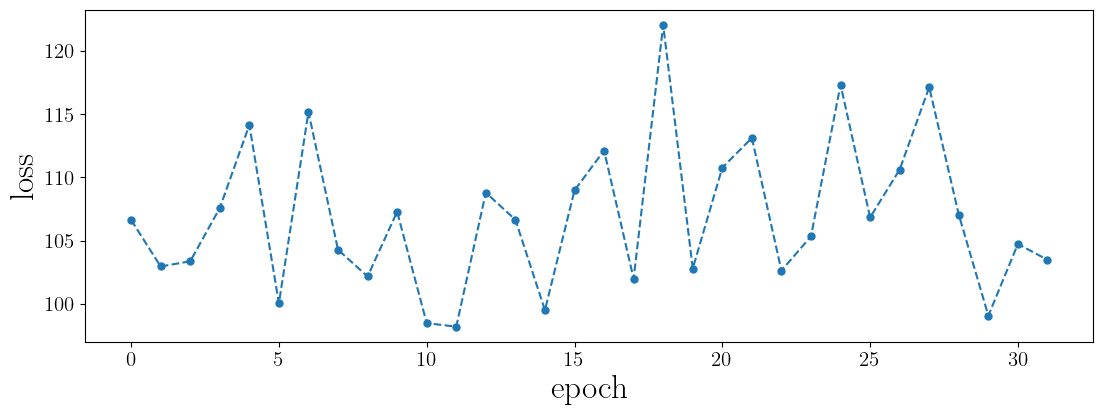

In [9]:
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update(matplotlib.rcParamsDefault) # restore to default settings
plt.rc("font", **{"family": "serif", "serif":["Computer Modern"]})
plt.rc("text", usetex=True)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(range(0, len(loss_array)), loss_array, "o", linestyle="--", markersize=5.)

ax.set_xlabel("epoch", fontsize=24)
ax.set_ylabel("loss", fontsize=24)

ax.tick_params(labelsize=15)

plt.subplots_adjust(
    top=0.97,
    bottom=0.14,
    left=0.13,
    right=0.97,
    hspace=0.,
    wspace=0.
)
plt.show()